# Inspect lenses and generate GLASS configs

## Imports

In [1]:
import sys
import os
import pprint
import json
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

from astropy.io import fits
from astropy.wcs import WCS
from astropy.nddata import Cutout2D

root = "/Users/phdenzel/gleam"
sys.path.append(root)
import gleam
from gleam.lensobject import LensObject
from gleam.multilens import MultiLens
from gleam.utils.plotting import IPColorbar, IPPointCache
import gleam.utils.colors as gcl
gcl.GLEAMcmaps.register_all()

## Main

### Search for a fits file

In [2]:
fidx = 4
files = !ls data/delay_qsos/*.fits
pprint.pprint(list(enumerate(files)))
filename = files[fidx]
lensname = os.path.basename(filename).split('.')[0].replace('-i', '').replace('-r', '').replace('_alt', '')
print("Selected file: {}".format(lensname))

[(0, 'data/delay_qsos/B0218+357.fits'),
 (1, 'data/delay_qsos/B1422+231.fits'),
 (2, 'data/delay_qsos/B1600+434.fits'),
 (3, 'data/delay_qsos/B1608+656.fits'),
 (4, 'data/delay_qsos/DESJ0408-5354.fits'),
 (5, 'data/delay_qsos/FBQ0951+2635.fits'),
 (6, 'data/delay_qsos/HE0435-1223.fits'),
 (7, 'data/delay_qsos/HE1104-1805.fits'),
 (8, 'data/delay_qsos/HE2149-2745.fits'),
 (9, 'data/delay_qsos/PG1115+080.fits'),
 (10, 'data/delay_qsos/PKS1830-211.fits'),
 (11, 'data/delay_qsos/Q0957+561.fits'),
 (12, 'data/delay_qsos/RXJ0911+0551.fits'),
 (13, 'data/delay_qsos/SBS0909+532.fits'),
 (14, 'data/delay_qsos/SBS1520+530.fits'),
 (15, 'data/delay_qsos/SDSSJ1004+4112.fits'),
 (16, 'data/delay_qsos/SDSSJ1206+4332.fits'),
 (17, 'data/delay_qsos/SDSSJ1650+4251-i.fits'),
 (18, 'data/delay_qsos/SDSSJ1650+4251-r.fits'),
 (19, 'data/delay_qsos/WFIJ2033-4723.fits')]
Selected file: DESJ0408-5354


### Get other infos for the configs

In [3]:
# fits table extracted from https://www.ast.cam.ac.uk/ioa/research/lensedquasars/index.html
qsos = fits.open("data/lensedquasars.fits")[1]

# JSON extracted from https://arxiv.org/abs/1002.2570
with open('data/table_1002.2570.json') as json_file:
    delay_qsos = json.load(json_file)

ValueError: Expecting , delimiter: line 262 column 5 (char 6881)

In [4]:
# info from fits table
lensedquasars_table = qsos.data
if 'WFI' in lensname:
    lensname = lensname.replace('J', '')
info_table = lensedquasars_table[lensedquasars_table['Name'] == lensname]
pprint.pprint(zip(info_table.dtype.names, info_table[0]))
table_keys = {'Name': ('name', lambda k: str(k[0])), 'z_lens': ('zl', lambda s: float(s.replace('?', ''))), 'z_qso': ('zs', float)}
info_table = {table_keys[name][0]: table_keys[name][1](info_table[name])
              for name in info_table.dtype.names if name in table_keys}


[('RA', 62.0905),
 ('DEC', -53.8999),
 ('Name', 'DESJ0408-5354'),
 ('z_qso', '2.375'),
 ('z_lens', '0.597'),
 ('separation', '4.29'),
 ('N_images', 4),
 ('W1', '14.0830001831'),
 ('W2', '13.1689996719')]


In [5]:
if 'WFI' in lensname:
    lensname = lensname.replace('WFI', 'WFIJ')
info_json = delay_qsos[[str(dct['shortname']).replace(" ", "") for dct in delay_qsos].index(lensname)]
positions = np.array([info_json[name] for name in ['x', 'y']]).T
json_keys = {'zl': 'zl', 'zs': 'zs', 'delays': 'delay'}
info_json = {json_keys[name]: info_json[name] for name in info_json.keys() if name in json_keys}
# info_json['name'] = lensname
info_json['srcimgs'] = positions
info_json['tdelay'] = [td[0] if td is not None else 0 for td in info_json['delay']]
info_json['tderr'] = [max(td[1], td[2]) if td is not None else 0 for td in info_json['delay']]
info_json

NameError: name 'delay_qsos' is not defined

In [6]:
info = info_json.copy()
info.update(info_table)
pprint.pprint(info)

NameError: name 'info_json' is not defined

### Read fits file

In [7]:
hdu = fits.open(filename)
hdu[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  

In [8]:
lo = LensObject(filename, auto=False, glscfactory_options={'name': info['name'], 'output': info['name']},
                zl=info['zl'], zs=info['zs'],
                tdelay=info['tdelay'], tderr=info['tderr'])
lo.lens = lo.center
for img in info['srcimgs']:
    lo.add_srcimg(lo.lens.xy+img/lo.px2arcsec, unit='pixel', relative=True)
# lo = MultiLens(filename)
print(lo.__v__)

NameError: name 'info' is not defined

In [10]:
%%script false
lo = LensObject(filename, auto=False)
print(lo.__v__)

Properties of that field are unknown [None]
filename            	DESJ0408-5354.fits
filepath            	/Users/phdenzel/delays/data/delay_qsos/DESJ0408-5354.fits
band                	
naxis1              	297
naxis2              	297
naxis_plus          	None
refval              	[62.071206545542, -53.897582756993]
refpx               	[124.0, 1201.0]
center              	<62.0708, -53.9092>
px2deg              	[1.100555579695338e-05, 1.1005555796953395e-05]
px2arcsec           	[0.03962000086903217, 0.039620000869032224]
megacam_range       	None
field               	None
photzp              	None
mag_formula         	<function mag_formula at 0x11dc69de8>
roi                 	ROISelector(297, 297)
lens                	None
srcimgs             	[]
zl                  	0.5
zs                  	3.0
mapr                	5.8836
tdelay              	None
tderr               	None
light_model         	{}
stel_mass           	None
glscfactory         	GLSCFactory(zl, srcimgs, parity, tderr.

In [11]:
if 'ORIENTAT' in lo.hdr:
    orientat = lo.hdr['ORIENTAT']
else:
    orientat = 0
orientat

-80.49998628637056

In [ ]:
print(lo.srcimgs_xy)

### Check out lens

<IPython.core.display.Javascript object>


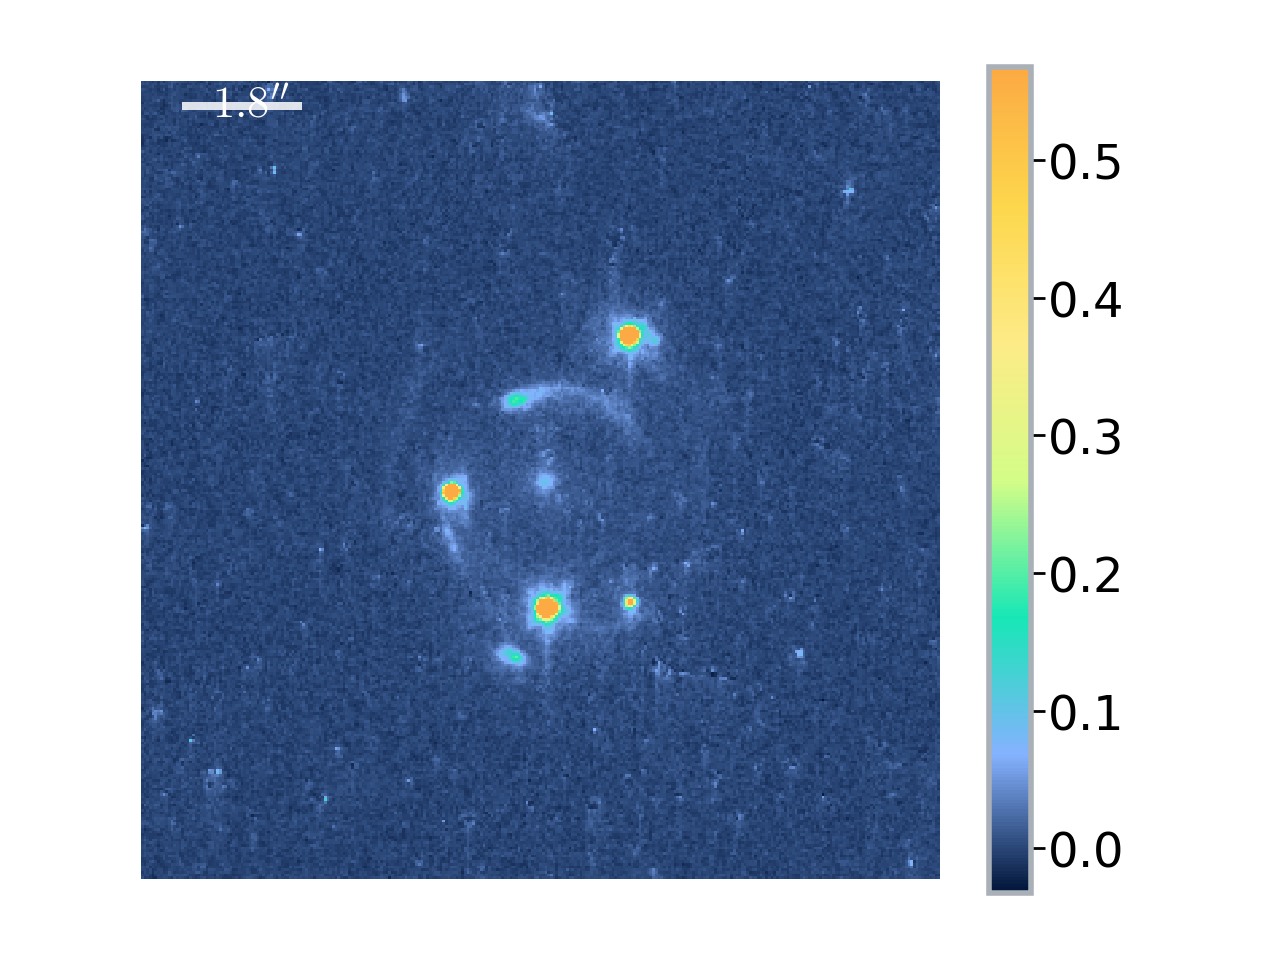

SEJveChjaGlsZHJlbj0oRHJvcGRvd24oZGVzY3JpcHRpb249dSdDb2xvcm1hcCcsIGluZGV4PTE4NiwgbGF5b3V0PUxheW91dCh3aWR0aD11JzEwMCUnKSwgb3B0aW9ucz0odSdBY2NlbnQnLCDigKY=


SEJveChjaGlsZHJlbj0oVGV4dGFyZWEodmFsdWU9dScnLCBkZXNjcmlwdGlvbj11J1BvaW50cycsIGxheW91dD1MYXlvdXQoaGVpZ2h0PXUnMjAwcHgnLCB3aWR0aD11Jzc1JScpLCBwbGFjZWjigKY=


In [12]:
%matplotlib notebook

fig, ax = plt.subplots()

# from matplotlib import transforms
# transf = transforms.Affine2D().rotate_deg(orientat) + ax.transData
# fig, ax, plt_out = lo.plot_f(fig, ax=ax, cmap=gcl.GLEAMcmaps.phoenix, colorbar=True,
#                              vmin=0, vmax=0.5*np.max(lo.data),
#                              lens=True, source_images=True, label_images=False, scalebar=False,
#                              transform=transf)

fig, ax, plt_out = lo.plot_f(fig, ax=ax, cmap=gcl.GLEAMcmaps.vilux, colorbar=True,
                             vmin=0, vmax=0.5*np.max(lo.data), source_images=False,
                             deconv=False, psf=np.ones((3, 3))/25.)
clrbar = IPColorbar(plt_out[1], plt_out[0])
clrbar.connect()
cache = IPPointCache(plt_out[0])
cid = cache.connect()

In [13]:
if cache.xy:
    subj = cache.modes.index('L')
    print(lo.px2arcsec)
    print(subj)
    d = cache.distances_to(subj, pixel_scale=np.array(lo.px2arcsec))
    pprint.pprint(d)
    pprint.pprint([np.sqrt(di[0]**2 + di[1]**2) for di in d])
    

[0.03962000086903217, 0.039620000869032224]
0
[[1.245994800023685, -2.1517111882405926],
 [0.04347029255249936, 1.8638715541984048],
 [1.2633021458035054, 1.7739854656669671],
 [-1.3680138795792833, 0.15302857747621412]]
[2.4864360195439987, 1.8643784049609073, 2.1778330385934974, 1.37654630152638]


In [ ]:
%%script false
# pprint.pprint(lo.hdr)
# print("Pixel coordinates")
# lens = lo.lens.xy
# pprint.pprint(lens)
# ABCD = lo.srcimgs_xy
# pprint.pprint(ABCD)

# print("Pixel scale")
# px2arcsec = lo.px2arcsec
# pprint.pprint(px2arcsec)

print("Arcsec coordinates")
arcsecs = np.array(lo.finder.relative_positions(lo.srcimgs, lo.lens))
# pprint.pprint(arcsecs)
pprint.pprint(info['srcimgs'])

# print("Maximal separation")
# pprint.pprint(lo.maprad)
# pprint.pprint([np.sqrt((x+y)**2) for (x, y) in arcsecs])

print("Time delay")
pprint.pprint(lo.tdelay)

### Save GLASS configs

In [ ]:
%%script false
lo.glscfactory.sync_lens_params()
configs = lo.glscfactory.config['single']
print("".join(configs))

In [ ]:
%%script false
savename = "{}.gls".format(lensname)
lo.glscfactory.write(filename=savename)